# Topic Modelling using Turing.jl 
# 用 Turing.jl 实现主题模型

徐锴 @ JuliaCN 2021

In [1]:
using FileIO, Distributions, Turing, StatsPlots
using Random: seed!
Turing.setadbackend(:tracker)
include("utilities.jl")
seed!(1)

MersenneTwister(1)

## Latent Dirichlet Allocation (LDA)

![](lda.jpg)

Image taken from https://devopedia.org/latent-dirichlet-allocation.

LDA 是一种生成模型，描述了以下生成过程来生成若干篇文章
- 对每个主题
  - $\beta \sim \mathcal{D}irichlet(\eta)$
- 对每篇文章
  - $\theta \sim \mathcal{D}irichlet(\alpha)$
  - 对文章里的每个词
    - $z \sim \mathcal{C}ategorical(\theta)$
    - $w \sim \mathcal{C}ategorical(\beta_z)$

下面是 LDA 在 Turing.jl 中的实现

In [2]:
@model function LatentDirichletAllocation(
    D,   # number of docs
         # 文本数量
    K,   # number of topics
         # 主题数量
    V,   # vocabulary
         # 字典大小
    N,   # doc length
         # 文本长度
    α,   # topic distribution hyperparameter
         # 主题分布的超参数
    η,   # word distribution (i.e. topic) hyperparameter
         # 词分布（即主题）的超参数
    z,   # per-word topic assignment
         # 每个词属于哪个主题
    w,   # observed words (i.e. documents)
         # 词的数据（即本文）
    doc, # doc ID for each word
         # 记录 w 中每个词属于哪个文本
)    
    β = Matrix{Real}(undef, V, K)
    for k in 1:K
        β[:,k] ~ Dirichlet(η)
    end

    θ = Matrix{Real}(undef, K, D)    
    ismissing(z) && (z = Vector{Int}(undef, D * N))
    ismissing(w) && (w = Vector{Int}(undef, D * N))
    ismissing(doc) && (doc = Vector{Int}(undef, D * N))
    i = 0
    for d in 1:D
        θ[:,d] ~ Dirichlet(α)
        for n in 1:N
            i += 1
            z[i] ~ Categorical(θ[:,d])
            w[i] ~ Categorical(β[:,z[i]])
            doc[i] = d
        end
    end
    # 这里我们生成的是 flattened 的数据，之后会有用
    # 例子：D = 2, K = 3, V = 4, N = 5
    #   z = [1, 3, 3, 3, 3, 2, 2, 1, 1, 1]
    #   w = [1, 3, 3, 4, 4, 1, 3, 1, 2, 2]
    # doc = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
    # 对应的矩阵形式是：
    #   Z = [1, 3, 3, 3, 3;
    #        2, 2, 1, 1, 1]
    #   W = [1, 3, 3, 4, 4;
    #        1, 3, 1, 2, 2]
    return (D=D, K=K, V=V, N=N, α=α, η=η, z=z, w=w, doc=doc, θ=θ, β=β)
end

LatentDirichletAllocation (generic function with 2 methods)

当实现了 LDA 后，我们也可以用同一个模型来生成数据。一般在进行概率建模的时候，可以用自己生成的数据来迭代 - 因为可以控制大小并且知道真实隐变量作为参考。

In [3]:
data = let D = 100, K = 10, V = 200, N = 25
    lda = LatentDirichletAllocation(D, K, V, N, ones(K), ones(V), missing, missing, missing)
    lda()
end

(D = 100, K = 10, V = 200, N = 25, α = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], η = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], z = [5, 7, 7, 3, 7, 2, 5, 2, 4, 7  …  7, 6, 10, 4, 4, 4, 10, 4, 4, 4], w = [32, 45, 98, 84, 168, 1, 170, 133, 177, 177  …  53, 48, 173, 6, 176, 185, 65, 22, 106, 117], doc = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  100, 100, 100, 100, 100, 100, 100, 100, 100, 100], θ = Real[0.016923012395941347 0.02364106092100972 … 0.12700031084260036 0.07880566888927307; 0.13916782435332334 0.1072026132032173 … 0.11443382669366144 0.15428792510180228; … ; 0.02452930196410011 0.29062579239263114 … 0.022737408539669837 0.03735851423578648; 0.01762786895278987 0.09863946861417414 … 0.07839417263735429 0.21064848687718923], β = Real[0.0029182386790862 0.0074906763501245395 … 0.002370810420987729 0.006597430290310369; 0.003102826045897398 0.005538110120876101 … 0.008987272851004717 0.0003189127771515677; … ; 0.00340

Turing.jl 提供了 `sample` 函数来进行推断，即给定数据，反推隐变量。这里我们假设只有 $\beta$ 和 $\phi$ 是需要推测的隐变量，调用 `sample` 函数来进行推断。

Sampling: 100%|█████████████████████████████████████████| Time: 0:03:11


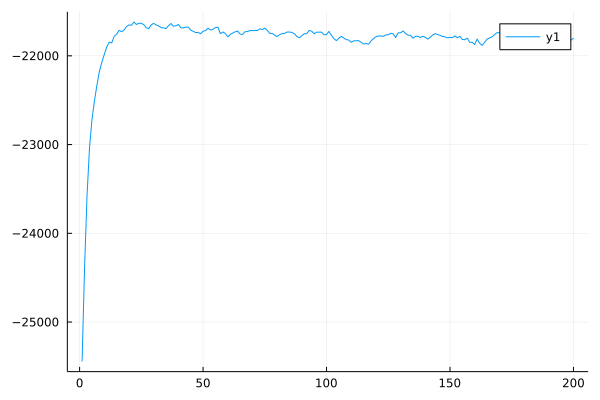

In [4]:
lda = LatentDirichletAllocation(data.D, data.K, data.V, data.N, data.α, data.η, data.z, data.w, data.doc)

chain = sample(lda, HMC(0.1, 3), 200)

plot(chain[:lp])

我们可以推断结果和用来生成数据的 $\beta$ 和 $\phi$ 比较，看推断是否正确。

In [5]:
retval = extract_expected_topic_parameters(chain, data.D, data.K, data.V, 100, 10)
retval.β - data.β

200×10 Matrix{Float64}:
  4.77913e-5    0.00192428    0.000470997  …   0.00223902    0.00339549
 -0.00152677    0.00455369    0.00371396       0.00172052    0.000723135
 -0.000338545   0.000186113  -0.0115376       -0.00255509   -0.000482624
  0.00252229    0.00231494    0.00810608       0.00216292    0.00373902
  0.000198109   0.00137956    0.00129168      -0.00530322   -0.00324321
  0.00153351    0.00464018   -0.00667384   …  -0.00183421    0.00138049
 -0.00624519    0.00291756    0.00335957       0.00221918    0.00283417
 -0.00622657    0.00120476    0.00190882       0.00142098   -0.000131298
  0.000359983   0.00026596    0.00223388      -0.000789659   0.00354039
 -0.00299921   -0.00260537    0.000940301      0.00277822    0.00182105
 -0.00438639   -0.00616029    0.00129444   …   0.00228644    0.00225869
 -0.00330338    0.00079588   -0.00236205      -0.00263376    5.86563e-5
  0.000802841   0.00156257   -0.00137758      -0.00186856   -0.00990522
  ⋮                                  

In [6]:
retval.θ - data.θ

10×100 Matrix{Float64}:
  0.0124936   0.0267323  -0.0146149   …   0.044525      0.0503729
  0.0390551   0.0310979   0.0361686      -0.05029      -0.066055
  0.0109067   0.0135917   0.0132852       0.0117225     0.0295779
 -0.0501852  -0.0449896  -0.148803       -0.045735      0.0249868
 -0.0309184   0.0133796   0.0645292       0.100622     -0.0251212
 -0.0169845   0.0917569   0.0253155   …   0.0184201     0.0315395
 -0.0371885  -0.0247026   0.0185794       0.0217097     0.00696624
  0.022992    0.0197761   0.00441159     -0.104145      0.00950627
  0.0250891  -0.166715    0.0352402       0.00387886   -0.0122301
  0.0247402   0.0400727  -0.0341121      -0.000707555  -0.0495432

-- 可以看到推断结果和真实隐变量是十分接近的。

上面这种实现方式虽然简单易懂，但是由于若干个循环，所以速度并不快。如果循环里每个概率分布都是独立，Turing.jl 支持构建一个分布列表（通过`filldist` 或者 `arraydist`）来使得推断更快。

Sampling: 100%|█████████████████████████████████████████| Time: 0:02:10


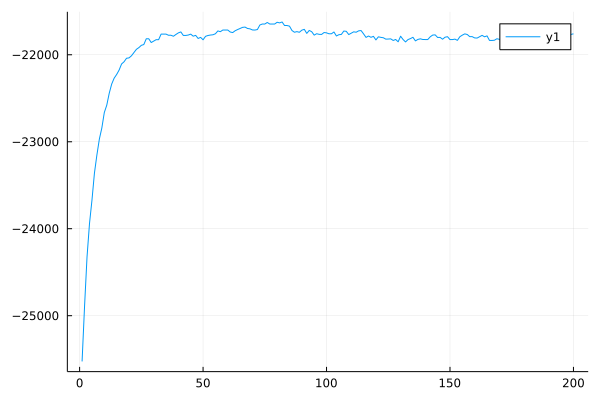

In [7]:
@model function LatentDirichletAllocationVectorized(
    D, K, V, α, η, z, w, doc
)
    β ~ filldist(Dirichlet(η), K)
    
    θ ~ filldist(Dirichlet(α), D)
    
    z ~ arraydist([Categorical(θ[:,doc[i]]) for i in 1:length(doc)])
    w ~ arraydist([Categorical(β[:,z[i]]) for i in 1:length(doc)])
end

lda = LatentDirichletAllocationVectorized(data.D, data.K, data.V, data.α, data.η, data.z, data.w, data.doc)

chain = sample(lda, HMC(0.1, 3), 200)

plot(chain[:lp])

-- 可以看到推断速度变快了。

到目前为止我们都假设 $z$ 是给定的，其实在实际情况中，数据只有文本中的词。对 LDA 而言，上面的模型可以把 $z$ 给 marginlize 掉。我们在 Turing.jl 里也很容易实现这个操作。

PS: 一般而言，假设 $p$ 是一个概率向量，$\beta$ 是一个矩阵其中每列都是一个概率向量，
$$z \sim \mathcal{C}ategorical(p), w \sim \mathcal{C}ategorical(\beta_z)$$
和
$$w \sim \mathcal{C}ategorical(\beta p)$$
对 $w$ 而言的概率分布一样。

Sampling: 100%|█████████████████████████████████████████| Time: 0:02:11


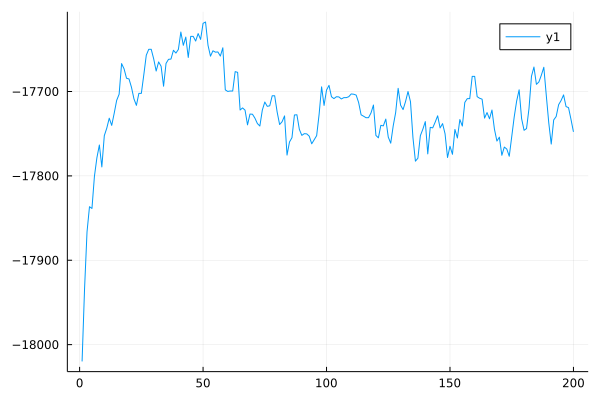

In [8]:
@model function LatentDirichletAllocationVectorizedCollapsed(
    D, K, V, α, η, w, doc
)
    β ~ filldist(Dirichlet(η), K)
    
    θ ~ filldist(Dirichlet(α), D)
    
    w ~ arraydist([Categorical(β * θ[:,doc[i]]) for i in 1:length(doc)])
end

lda = LatentDirichletAllocationVectorizedCollapsed(data.D, data.K, data.V, data.α, data.η, data.w, data.doc)

chain = sample(lda, HMC(0.1, 3), 200)

plot(chain[:lp])

-- 可以看到我们现在不需要提供 $z$ 就可以进行推断了。与此同时，因为少考虑了一个变量，速度也变快了。

仔细观察模型中的计算，我们发现因为 `doc[i]` 有很多重复的值，所以 `β * θ[:,doc[i]]` 会有很多重复计算了。我们可以通过先计算 `β * θ` 来避免重复计算。

Sampling: 100%|█████████████████████████████████████████| Time: 0:01:07


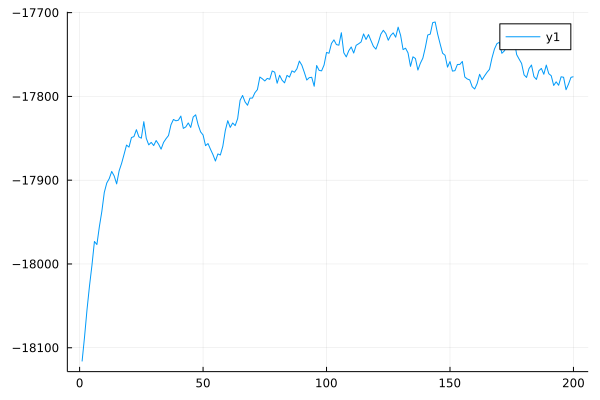

In [9]:
@model function LatentDirichletAllocationVectorizedCollapsedOptimized(
    D, K, V, α, η, w, doc
)
    β ~ filldist(Dirichlet(η), K)
    
    θ ~ filldist(Dirichlet(α), D)
    
    product = β * θ
    dist = [Categorical(product[:,i]) for i in 1:D]
    
    w ~ arraydist([dist[doc[i]] for i in 1:length(doc)])
end

lda = LatentDirichletAllocationVectorizedCollapsedOptimized(data.D, data.K, data.V, data.α, data.η, data.w, data.doc)

chain = sample(lda, HMC(0.05, 3), 200)

plot(chain[:lp])

-- 可以看到推断速度进一步变快了。

如果想要进一步加快推断，需要了解一些 Turing.jl 底层的操作。
- 如果 `~` 左侧是数据，Turing.jl 实际上就是就是算了数据的 log-probability 并且累加起来。
- 对于 categorical distribution（分类分布）而言，如果概率参数是 `p`，数据是一个正整数 `w`，那么对应的 log-probability 就是 `log.(p[w])`。
我们可以通过这一技巧，加上直接调用 Turing.jl 提供的 `@addlogprob!` 来替代最后一行代码。

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:35


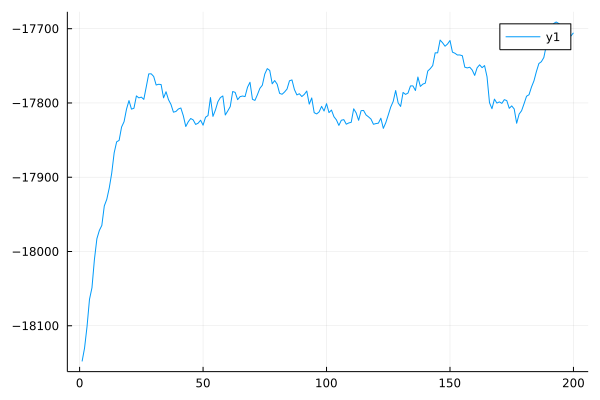

In [10]:
@model function LatentDirichletAllocationVectorizedCollapsedMannual(
    D, K, V, α, η, w, doc
)
    β ~ filldist(Dirichlet(η), K)
    
    θ ~ filldist(Dirichlet(α), D)
    
    log_product = log.(β * θ)
    Turing.@addlogprob! sum(log_product[CartesianIndex.(w, doc)])
end

lda = LatentDirichletAllocationVectorizedCollapsedMannual(data.D, data.K, data.V, data.α, data.η, data.w, data.doc)

chain = sample(lda, HMC(0.05, 3), 200)

plot(chain[:lp])

-- 可以看到推断速度比之前更快了。

现在我们把这个模型在 20 Newsgroups 数据集上测试一下。
20 Newsgroups 收集了大约20,000左右的新闻组文档，均匀分为20个不同主题的新闻组集合。
我们这里只采用这个数据集里的 1,000 个新闻文档来进行实验。
我们这里设定 $K$ 为 10，即挖掘 10 个文本主题。

PS：数据经过 tokenization 预处理。

Sampling: 100%|█████████████████████████████████████████| Time: 0:34:56


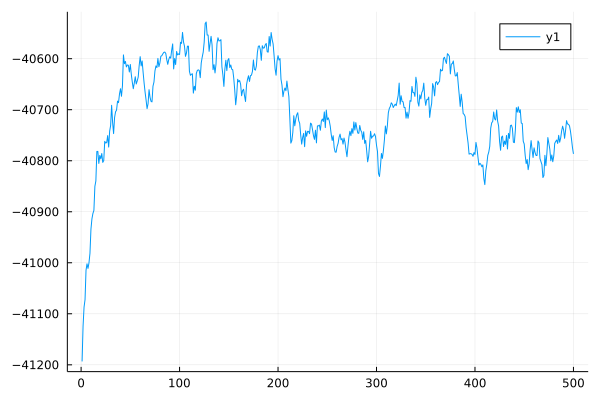

In [11]:
data_20news = load("20news-sub.jld2")
data_20news["K"] = 10

lda = LatentDirichletAllocationVectorizedCollapsedMannual(
    data_20news["D"], data_20news["K"], data_20news["V"], ones(data_20news["K"]), ones(data_20news["V"]), data_20news["w"], data_20news["doc"]
)

chain = sample(lda, HMC(0.05, 3), 500)

plot(chain[:lp])

我们可以对推断出来的文本主题进行可视化。这里我们生成 10 个主题对应的 word cloud.

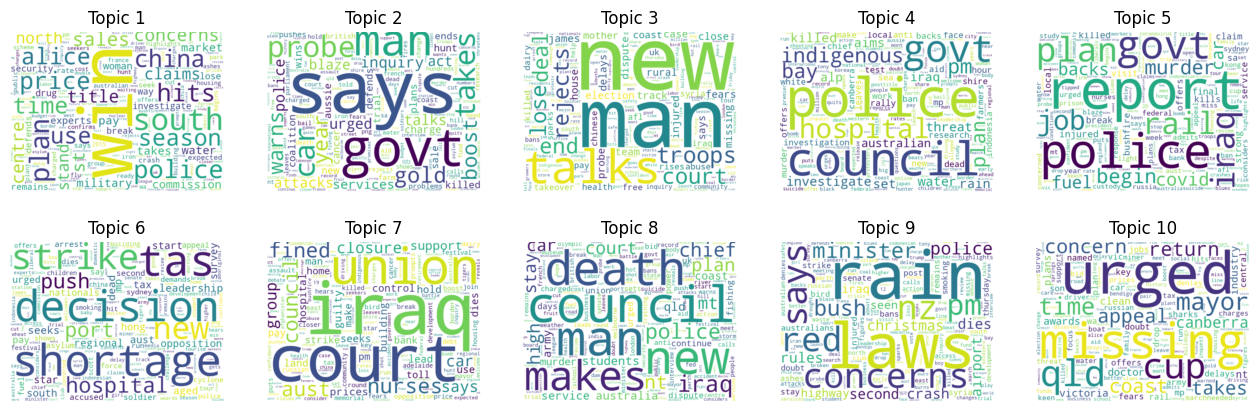

In [12]:
retval = extract_expected_topic_parameters(chain, data_20news["D"], data_20news["K"], data_20news["V"], 100, 10)
make_word_clouds_plot(retval.β, data_20news["vocab"])

通过 Turing.jl 来实现主题模型而不是用一些已有的实现的一个优势是我们可以很容易的对模型进行更改。
比如 [1] 提出了一个 LDA 的变种，将 LDA 中 mixture of experts 的假设改为了 product of experts，能够让每个文档更灵活得使用每个主题的词分布。
在 Turing.jl 中实现这个模型只需要做几处修改：

1. 将 $\beta$ 的生成分布改为 normal (`Normal`) 并用 `softmax` 确保每列是概率（重参数化）
2. 将 $\theta$ 的生成分布改为 normal (`Normal`)
3. 在算每个文档的词的概率的时候用 `softmax` 来使得每列都是概率分布。
  - 因为最后要取 $\log$，这里直接使用 `logsoftmax`.

[1] Srivastava, A. and Sutton, C., 2017. Autoencoding variational inference for topic models.

Sampling: 100%|█████████████████████████████████████████| Time: 0:06:29


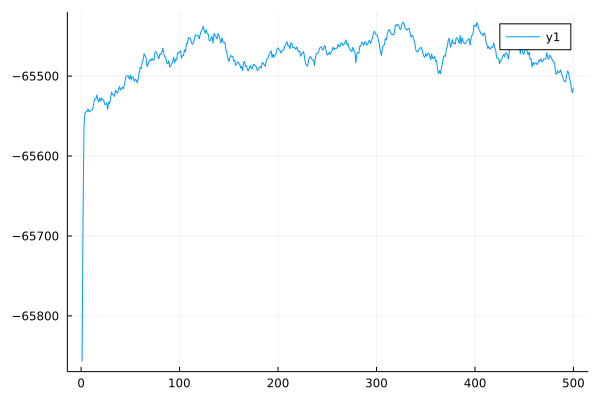

In [13]:
using NNlib: softmax, logsoftmax, softplus

@model function ProductLatentDirichletAllocationVectorizedCollapsedMannual(
    D, K, V, w, doc
)
    β ~ filldist(Normal(0, 5), V, K)
    
    θ ~ filldist(Normal(0, 5), K, D)
    
    log_product = logsoftmax(softmax(β; dims=1) * softplus.(θ); dims=1)
    Turing.@addlogprob! sum(log_product[CartesianIndex.(w, doc)])
end

lda = ProductLatentDirichletAllocationVectorizedCollapsedMannual(
    data_20news["D"], data_20news["K"], data_20news["V"], data_20news["w"], data_20news["doc"]
)

chain = sample(lda, HMC(0.01, 15), 500)

plot(chain[:lp])

最后，我们同样对推断出来的文本主题进行可视化。

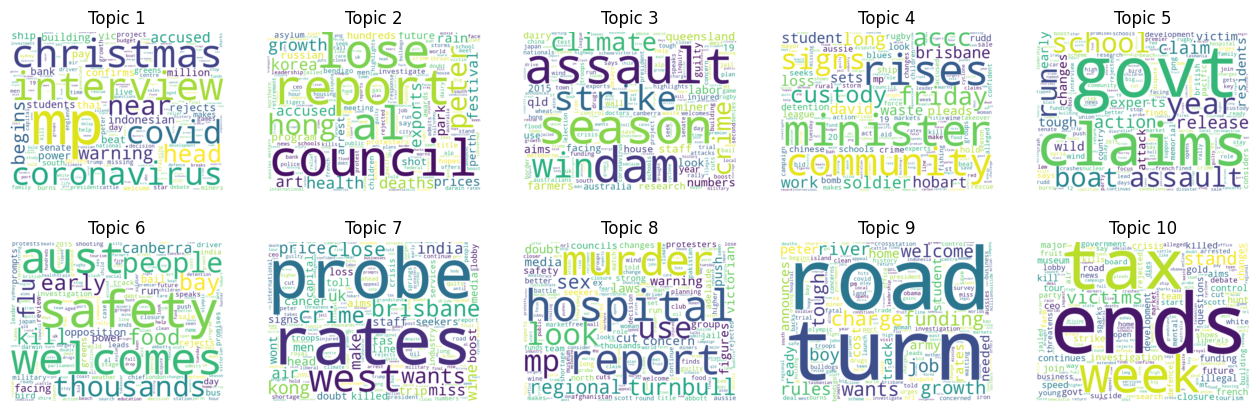

In [14]:
retval = extract_expected_topic_parameters(chain, data_20news["D"], data_20news["K"], data_20news["V"], 100, 10)
make_word_clouds_plot(retval.β, data_20news["vocab"])